2026-02-11 13:42:34.209 | INFO     | kfactory.kcell:show:3995 - klive v0.4.1: Reloaded file '/tmp/interactiveshell_run_code.oas'


┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer ┃ center ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━┩
└──────┴───────┴─────────────┴───────┴────────┴───────────┘

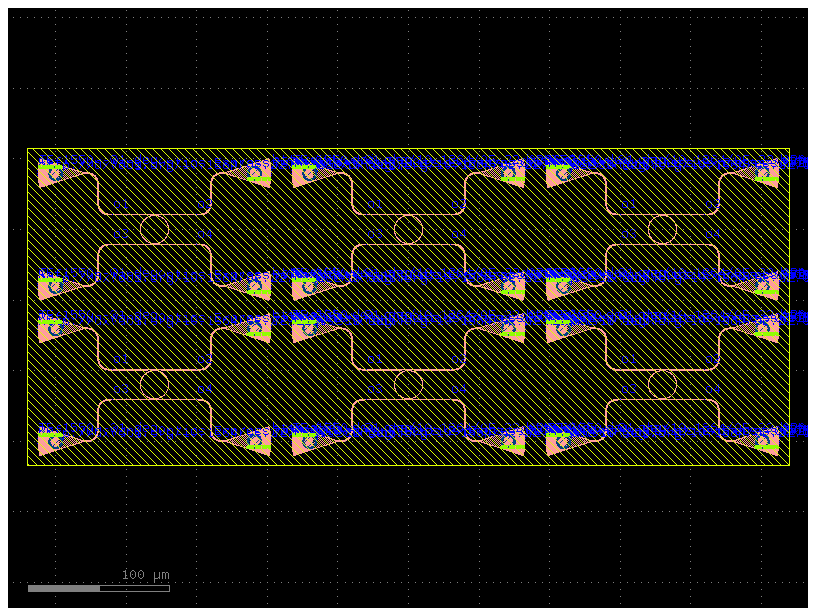

In [5]:
########### For open EBL submission ##############

import sys
sys.path.append('/home/matthew/photonics562/Photonics-Bootcamp/SiEPIC_EBeam_PDK/klayout/EBeam/pymacros/pcells_EBeam_Beta')
# import pya
# from pya import *
# from SiEPIC.utils import get_technology_by_name
# from SiEPIC.utils.layout import make_pin,new_layout
# import siepic_ebeam_pdk
# cell, ly = new_layout("EBeam", "ring_res", GUI=True)  
# from SWG_Ring import SWG_Ring  
# from Waveguide_SWG import Waveguide_SWG
# from Waveguide_SWG_to_Strip import Waveguide_SWG_to_Strip
# import tempfile
# import os
import gdsfactory as gf  
from gdsfactory.typings import LayerSpec  
from gdsfactory.technology import LayerMap  
from gdsfactory.typings import Layer
import numpy as np
import math
from gdsfactory.snap import snap_to_grid  




#####################
# Clear
#####################
gf.clear_cache()


#####################
# PDK / LAYERS / DRC
#####################

class OpenEBL_Layers(LayerMap):  
    """Custom layer mapping for your PDK."""  
    # Fabricated layers  
    SI: Layer = (1, 0)  # Silicon geometries  
    # Virtual layers    
    FLOORPLAN: Layer = (99, 0)  # Layout design area  
    TEXT: Layer = (10, 0)  # Text labels  
    DEVREC: Layer = (68, 0)  # Device recognition  
    PINREC: Layer = (1, 10)  # Port/pins recognition  
    WAVEGUIDE: Layer = (1, 99)  # Waveguide guiding shape  
    SEM: Layer = (200, 0)  # SEM image requests  LAYERS = OpenEBL_Layers

OPENEBL_PDK = gf.Pdk(  
    name="openEBL",  
    layers=OpenEBL_Layers,  
)  

LAYERS = OpenEBL_Layers

# DRC constants for SiEPIC_EBeam_PDK  
MIN_SI_FEATURE = 0.07  # 70 nm minimum Si feature size  
MIN_SI_SPACE = 0.07    # 70 nm minimum Si spacing  


gf.gpdk.PDK.activate()


#####################
# New Cells
#####################

 # Instantiate the Pcell Parameters
# pitch  SWG Period [um]
# w  Waveguide Width [um]
# r  Ring Radii [um]
# ff SWG Duty Cycle [%]
# angle Angle of the ring
# gap2 Coupling Gap [um]
# busL Bus Length [um]
# taperL Taper Length [um]

gc_gds = "/home/matthew/photonics562/Photonics-Bootcamp/SiEPIC_EBeam_PDK/klayout/EBeam/gds/EBeam/ebeam_gc_te1550.gds"
gc_component = gf.import_gds(gc_gds, cellname="ebeam_gc_te1550", rename_duplicated_cells=True)
gc_component = gf.add_ports.add_ports_from_markers_center(
        gc_component,
        pin_layer=LAYERS.PINREC,
        port_layer=LAYERS.SI,
        # inside=True
    )
gc_component.remove_layers(layers=[LAYERS.PINREC, LAYERS.DEVREC], recursive=True)   
    
@gf.cell  
def swg_ring_double_bus(pitch: float = 0.2,  w: float = 0.5, ff: float = 0.5, angle: float = 360, gap2: float = 0.6, taperL: float = 5, r: float = 10,  layer: LayerSpec = LAYERS.SI, x_center: float = 0, y_center: float = 0) -> gf.Component:
    c = gf.Component() 
    
    
    pi = math.pi
    
    # Minimize Ring Radii to 5 um
    if r - w / 2 <= 0:
        r = 5
    
    # Bus waveguide should be longer than 2x*taperL + 10 um for coupling
  
    busL = taperL * 2 + 10
        
    # Calculate number of SWG segments within the resonator
    s1 = pitch * ff  # silicon
    s2 = pitch - s1  # gap

    ####### Draw the Multi-box Ring

    # Calculate a radius to fit all of the gratings
    const = math.floor(2 * pi * r / (s1 + s2))
    # if doesn't divide evenly, replace r with best possible r
    if (2 * pi * r) % (s1 + s2) != 0:
        r = const * (s1 + s2) / (2 * pi)
     
    # Draw the SWGs
    theta1 = math.atan(s1 / r)
    theta2 = math.atan(s2 / r)
    nSeg = int(
        math.floor(angle / (math.degrees(theta1) + math.degrees(theta2)))
    )  # NUmber of SWG segments

    si_first = True  # for alternating between silicon and gap
    j = 0  # Index of how many silicon thetas
    jj = 0  # Index of how many gap thetas
    ORDER = True  # Ordering of the coordinates for polygon drawing

    xo = [(r - w / 2) * math.cos(0)]
    yo = [(r - w / 2) * math.sin(0)]
    xo.append((r + w / 2) * math.cos(0))
    yo.append((r + w / 2) * math.sin(0))

    for i in range(0, nSeg * 2):
        if si_first:
            j = j + 1
            si_first = not (si_first)
        else:
            jj = jj + 1
            si_first = not (si_first)

        if ORDER:
            xo.append((r + w / 2) * math.cos(j * theta1 + jj * theta2))
            yo.append((r + w / 2) * math.sin(j * theta1 + jj * theta2))
            xo.append((r - w / 2) * math.cos(j * theta1 + jj * theta2))
            yo.append((r - w / 2) * math.sin(j * theta1 + jj * theta2))
            ORDER = not (ORDER)
        else:
            xo.append((r - w / 2) * math.cos(j * theta1 + jj * theta2))
            yo.append((r - w / 2) * math.sin(j * theta1 + jj * theta2))
            xo.append((r + w / 2) * math.cos(j * theta1 + jj * theta2))
            yo.append((r + w / 2) * math.sin(j * theta1 + jj * theta2))
            ORDER = not (ORDER)

        if len(xo) == 4:
            points = list(zip(xo, yo))  # Convert to list of (x, y) tuples in um  
            c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling  
            xo = []  
            yo = []  
    r = r - w

    # Draw the Bus Waveguides
    const = math.floor(2 * pi * r / (s1 + s2))

    # If doesn't divide evenly, replace r with best possible r
    if (2 * pi * r) % (s1 + s2) != 0:
        r = const * (s1 + s2) / (2 * pi)

    # calulate ideal length of bus
    bus_length = busL
    constant = math.ceil(bus_length / (s1 + s2))
    if bus_length % (s1 + s2) != 0:
        bus_length = constant * (s1 + s2)

    xo = [
        (r + w / 2 + gap2),
        (r + w / 2 + gap2 + w),
        (r + w / 2 + gap2 + w),
        (r + w / 2 + gap2),
    ]
    yo = [0, 0, s1, s1]
    points = list(zip(xo, yo))  # Convert to list of (x, y) tuples in um 
    c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling  
    
    # draw the bus waveguide
    for i in range(0, int(math.ceil((constant) / 2))):
        yu = [yo[j] + i * pitch for j in range(len(yo))]
        yd = [yo[j] - i * pitch for j in range(len(yo))]

        points = list(zip(xo, yu))  # Convert to list of (x, y) tuples in um 
        points_mirrored = [(-x, y) for x, y in points] 
        c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling
        c.add_polygon(points_mirrored, layer=layer)  # gdsfactory handles DBU scaling
        points = list(zip(xo, yd))  # Convert to list of (x, y) tuples in um 
        points_mirrored = [(-x, y) for x, y in points] 
        c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling
        c.add_polygon(points_mirrored, layer=layer)  # gdsfactory handles DBU scaling
        
   
     

    # draw the tapers from waveguide to SWG
    xtu = [
        ((r + w / 2 + gap2) + (w - 0.06) / 2),
        ((r + w / 2 + gap2) + (w - 0.06) / 2 + 0.06),
        ((r + w / 2 + gap2) + w),
        (r + w / 2 + gap2),
    ]
    ytu = [(yu[3] - taperL), (yu[3] - taperL), (yu[3]), (yu[3])]
  
    
    points = list(zip(xtu, ytu))  # Convert to list of (x, y) tuples in um 
    points_mirrored = [(-x, y) for x, y in points] 
    c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling
    c.add_polygon(points_mirrored, layer=layer)  # gdsfactory handles DBU scaling

    ytd = [(yd[1] + taperL), (yd[1] + taperL), (yd[1]), (yd[1])]
    points = list(zip(xtu, ytd))  # Convert to list of (x, y) tuples in um 
    points_mirrored = [(-x, y) for x, y in points] 
    c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling
    c.add_polygon(points_mirrored, layer=layer)  # gdsfactory handles DBU scaling


    # Bus Strip Waveguide
    xTu = [min(xtu), min(xtu), min(xtu) + w, min(xtu) + w]
    yTu = [max(ytu), round(max(ytu) + busL), round(max(ytu) + busL), max(ytu)]

    points = list(zip(xTu, yTu))  # Convert to list of (x, y) tuples in um 
    points_mirrored = [(-x, y) for x, y in points] 
    c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling
    c.add_polygon(points_mirrored, layer=layer)  # gdsfactory handles DBU scaling
 

    yTd = [min(ytd), round(min(ytd) - busL), round(min(ytd) - busL), min(ytd)]

    points = list(zip(xTu, yTd))  # Convert to list of (x, y) tuples in um 
    points_mirrored = [(-x, y) for x, y in points] 
    c.add_polygon(points, layer=layer)  # gdsfactory handles DBU scaling
    c.add_polygon(points_mirrored, layer=layer)  # gdsfactory handles DBU scaling
 
    
    c = gf.add_pins.add_bbox(  
        c,  
        bbox_layer=LAYERS.DEVREC,  
        left=gap2 / 2,   # adjust margins as needed  
        right=gap2 / 2,  
        top=0.5,  
        bottom=0.5,  
    )  

    c.add_port(  
        name="o1",  
        center=snap_to_grid((max(xTu) - w / 2, max(yTu))),  
        width=snap_to_grid(w),  
        orientation=90,  
        layer=LAYERS.SI,          # pin marker layer  
    )  
    c.add_port(  
        name="o2",  
        center=snap_to_grid((max(xTu) - w / 2, min(yTd))),  
        width=snap_to_grid(w),    
        orientation=270,  
        layer=LAYERS.SI,          # pin marker layer  
    )
    
    # Add ports for mirrored bus  
    c.add_port(  
        name="o3",  
        center=snap_to_grid((-max(xTu) + w / 2, max(yTu))),  
        width=snap_to_grid(w),  
        orientation=90,  
        layer=LAYERS.SI,  
    )  
    c.add_port(  
        name="o4",   
        center=snap_to_grid((-max(xTu) + w / 2, min(yTd))),  
        width=snap_to_grid(w),    
        orientation=270,  
        layer=LAYERS.SI,  
    )  
  
    # Optional: add visual pin markers (e.g., triangles or squares)  
    c = gf.add_pins.add_pins_container(c, layer=LAYERS.PINREC, layer_label=LAYERS.TEXT)
    
    
    

    
    c1 = gf.Component()

    g_horiz_spacing = 100
    g_horiz_pos = g_horiz_spacing / 2

    g_vert_spacing = 80
    g_vert_pos = g_vert_spacing / 2

    ring = c1 << c
    ring.rotate(90)
    ring.move((x_center,y_center))

    # top ports

    g_in = c1 << gc_component
    g_in.move((-g_horiz_pos +x_center,g_vert_pos+y_center))
    g_through = c1 << gc_component
    g_through.rotate(180)
    g_through.move((g_horiz_pos +x_center,g_vert_pos+y_center))


    g_drop = c1 << gc_component
    g_drop.move((-g_horiz_pos+x_center,-g_vert_pos+y_center))
    g_add = c1 << gc_component
    g_add.rotate(180)
    g_add.move((g_horiz_pos+x_center,-g_vert_pos+y_center))



    def inspect_component(name, component):
        print(f'\n{name} SPECS')
        component.pprint_ports()
        print(f'{name} layers', component.layers)
        for l in component.layers:
            print(f'{name} polygons', component.get_polygons(layers=[l]))
        for l in component.layers:
            labels = component.get_labels(layer=l) 
            for label in labels:
                print(f'label {l}: ', label.string, label.x, label.y)
                

    


    xs = gf.cross_section.cross_section(layer=LAYERS.SI, width=0.5, radius=10.0)  




    # Connect opposite waveguide ends to grating couplers  
    gf.routing.route_single(c1, ring.ports['o1'], g_in['o1'], cross_section=xs)#,start_straight_length=0.0, end_straight_length=0.0)  
    gf.routing.route_single(c1, ring.ports['o2'], g_through['o1'], cross_section=xs)#,start_straight_length=0.0, end_straight_length=0.0)  
    gf.routing.route_single(c1, ring.ports['o3'], g_drop['o1'], cross_section=xs)#,start_straight_length=0.0, end_straight_length=0.0)  
    gf.routing.route_single(c1, ring.ports['o4'], g_add['o1'], cross_section=xs)#,start_straight_length=0.0, end_straight_length=0.0)
    gf.add_pins.add_bbox(  c1,  bbox_layer=LAYERS.DEVREC, top=2, bottom=2,left=2,right=2)
    
    c1.flatten()
        
    return c1





c = gf.Component()

# default values
# def swg_ring_double_bus(
#     pitch: float = 0.2,  
#     w: float = 0.5,
#     ff: float = 0.5, 
#     angle: float = 360, 
#         gap2: float = 0.6, 
#         taperL: float = 5, 
#         r: float = 10,  
#         layer: LayerSpec = LAYERS.SI, 
#         x_center: float = 0, 
#         y_center: float = 0) -> gf.Component:
# double_ring_1 = c << swg_ring_double_bus()


ff = 0.5
shift_y = -110
shift_x = 180
double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.2, w=0.5, r=10, x_center= 0,y_center=0)
double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.25, w=0.5, r=10, x_center=-shift_x,y_center=0.)
double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.3, w=0.5, r=10, x_center=shift_x,y_center=0.)
double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.35, w=0.5, r=10, x_center= 0,y_center=shift_y)
double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.4, w=0.5, r=10, x_center=-shift_x,y_center=shift_y)
double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.45, w=0.5, r=10, x_center=shift_x,y_center=shift_y)

# double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.3, w=0.5, r=10, x_center= -150,y_center=-150)
# double_ring_1 = c << swg_ring_double_bus(ff=0.5, pitch= 0.35, w=0.5, r=10, x_center= 150,y_center=0)

# double_ring_2 = c << swg_ring_double_bus(ff=ff, pitch= 0.35, w=0.8, r=15, x_center=150,y_center=0)
# double_ring_3 = c << swg_ring_double_bus(ff=ff, pitch= 0.25, w=0.8, r=15, x_center=0,y_center=0)


gf.add_pins.add_bbox(c,  bbox_layer=LAYERS.FLOORPLAN, top=5, bottom=5,left=5,right=5) 

c.flatten()
# Export to GDS (without metadata for Calibre compatibility)

file_name =  "/home/matthew/photonics562/Photonics-Bootcamp/openEBL-2026-02/submissions/EBeam_mmcmurray123_double_bus_swg_ring_final.gds" 
c.write_gds(file_name, with_metadata=False)  
  
# Optional: Visualize the design  
c.plot()  

lyrdb = c.connectivity_check(port_types=("optical", "electrical"))  
filepath = gf.config.home / "errors.lyrdb"  
lyrdb.save(filepath)  
gf.show(c, lyrdb=filepath)



c.pprint_ports()



